This notebook uses Brian2 to implement the Izhikevich neuron and STDP.

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from __future__ import division

from brian2 import *
from itertools import *

In [5]:
sns.set()
sns.set_style("white", rc={
    'axes.grid': False,
    'axes.labelcolor': '0.4',
    'axes.edgecolor': '0.8',
    'axes.facecolor': '1.0',
    'text.color': '0.4',
    'xtick.color': '0.4',
    'ytick.color': '0.4',
    'axes.linewidth': 2,
})
palette = sns.color_palette("Set2", 10)
sns.set_palette(palette)
sns.set_context("notebook", font_scale=1.2)

In [6]:
model = '''
w : 1
w_max : 1 (constant)
w_min : 1 (constant)
eta_pos : 1 (constant)
eta_neg : 1 (constant)
tau_pos : second (constant)
tau_neg : second (constant)
a_pos : 1 (constant)
a_neg : 1 (constant)
dx/dt = -x / tau_neg : 1 (event-driven) # pre-synaptic trace
dy/dt = -y / tau_pos : 1 (event-driven) # post-synaptic trace
'''

pre = '''
I_post += w * v_peak
y = a_pos
w = clip(w + (eta_neg * x), w_min, w_max)
'''

post='''
x = a_neg
w = clip(w + (eta_pos * y), w_min, w_max)
'''

In [7]:
tau = 1*ms
v_peak = 30.

In [27]:
eqs = '''
dv/dt = (.04 * (v**2) + 5. * v + 140. - u + I) / tau : 1
du/dt = (a * (b * v - u)) / tau : 1
I : 1
a : 1 (constant)
b : 1 (constant)
c : 1 (constant)
d : 1 (constant)
'''

threshold = 'v > v_peak'

reset = '''
v = c
u += d
'''

reset_I = '''
I = 0
'''

In [69]:
duration = 1000*ms

G = NeuronGroup(1, eqs, threshold=threshold, reset=reset)
G.a = .02
G.b = .2
G.c = -65.
G.d = 2.
G.v = 'c'
G.u = 'b * v'

I_reset = G.custom_operation(reset_I, when='thresholds')

P = PoissonInput(G, 'I', 1, 100*Hz, weight=200.)

M_state = StateMonitor(G, ('v', 'u', 'I'), record=True)
M_rate = PopulationRateMonitor(G)

N = Network(G, P, M_state, M_rate, I_reset)
N.run(duration)

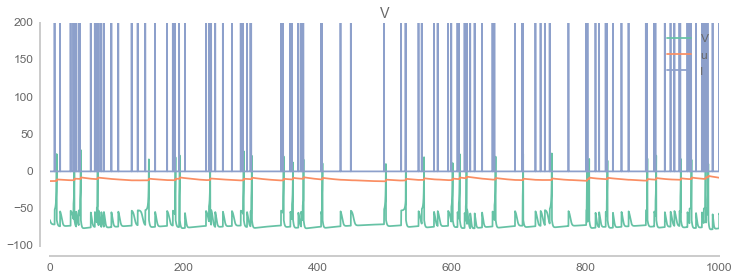

In [70]:
# plot V
figure(figsize=(12, 4))
plot(M_state.t/ms, M_state.v[0], label='V')
plot(M_state.t/ms, M_state.u[0], label='u')
plot(M_state.t/ms, M_state.I[0], label='I')

sns.despine(offset=10, trim=True)
title("V")
legend(loc="best")

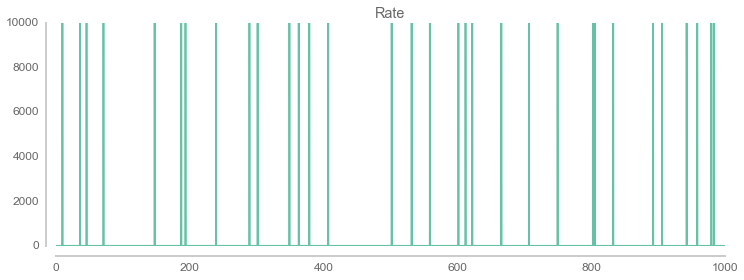

In [71]:
# plot spike rate
figure(figsize=(12, 4))
plot(M_rate.t/ms, M_rate.rate/Hz)

sns.despine(offset=10, trim=True)
title("Rate")
legend(loc="best")